In [1]:
!pip install torchxrayvision --quiet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import copy
import time
import torchxrayvision as xrv

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 200
NUM_CLASSES = 5

# Train: Heavy augmentation (Rotation, Shift, Zoom/Crop, Flip, Brightness)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Ensure 1 channel
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # shift width/height
    transforms.ColorJitter(brightness=0.2), # brightness 0.8-1.2
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Converts to [0,1]
])

# Val: No augmentation, just resize and rescale
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
train_dir = '/kaggle/input/koa-xray/XRAY/train'
val_dir = '/kaggle/input/koa-xray/XRAY/val'      

# Load Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 5779
Validation samples: 856


# Custom CNN Architecture

In [6]:
# Calculate Class Weights 
y_train_indices = train_dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)

# Convert to Tensor and move to GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Class Weights: [0.5055993  1.10497132 0.76240106 1.52480211 6.68092486]


In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        
        # Block 1 (Input: 224x224 -> Output: 112x112)
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Block 2 (Input: 112x112 -> Output: 56x56)
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.30)
        )
        
        # Block 3 (Input: 56x56 -> Output: 28x28)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.35)
        )

        # Block 4 (Input: 28x28 -> Output: 14x14)
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.40) # Higher dropout deeper in the network
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x) 
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

Training Loop

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, num_epochs=50, patience=20, save_path='best_model.pth'):
    """
    Universal training function with Scheduler support.
    """
    print(f"Starting training for {num_epochs} epochs. Best model will be saved to '{save_path}'")
    
    model = model.to(device)
    
    # History tracking
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Early Stopping Setup
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    start_time = time.time()

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        
        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        # --- SCHEDULER STEP ---
        if scheduler:
            # ReduceLROnPlateau steps based on metric (val_loss)
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                # Other schedulers (StepLR) step per epoch
                scheduler.step()

        # Update History
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.2f}%")
        
        # --- EARLY STOPPING & CHECKPOINTING ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
            print(f"  >>> New Best Model Saved! (Val Loss: {epoch_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print("Early stopping triggered. Stopping training.")
            break
            
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

Evaluation

In [9]:
def evaluate_model(model, test_loader, device, classes=['0', '1', '2', '3', '4'], title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"Evaluating model...")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # 1. Print Classification Report
    print("\n" + "="*30)
    print(f"CLASSIFICATION REPORT: {title}")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=classes, digits=4))
    
    # 2. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [10]:
# --- DEFINING RGB LOADERS FOR TRANSFER LEARNING MODELS ---

# ImageNet models require 3 channels and specific normalization
rgb_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels (RGB)
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*rgb_stats)
])

val_transforms_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*rgb_stats)
])

# Load Data
train_dataset_rgb = datasets.ImageFolder(root=train_dir, transform=train_transforms_rgb)
val_dataset_rgb = datasets.ImageFolder(root=val_dir, transform=val_transforms_rgb)

# Create RGB Loaders
train_loader_rgb = DataLoader(train_dataset_rgb, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_rgb = DataLoader(val_dataset_rgb, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("RGB Loaders created for AlexNet and DenseNet (ImageNet).")

RGB Loaders created for AlexNet and DenseNet (ImageNet).


In [11]:
def get_finetuned_alexnet(num_classes=5):
    print("Initializing Fine-Tuned AlexNet...")
    model = models.alexnet(weights="DEFAULT")
    
    # 1. Freeze EVERYTHING first
    for param in model.parameters():
        param.requires_grad = False
        
    # 2. Unfreeze the Last Convolutional Layer (Index 10)
    # AlexNet Features: Conv1(0)... Conv5(10) ...
    for param in model.features[10].parameters():
        param.requires_grad = True
        
    # 3. Unfreeze the entire Classifier (High level reasoning)
    # or just replace the last layer depending on strategy. 
    # Here we unfreeze the whole classifier to allow maximum adaptation.
    for param in model.classifier.parameters():
        param.requires_grad = True

    print("  -> Frozen layers: Conv 1-4")
    print("  -> Unfrozen layers: Conv 5, All Linear Layers")

    # 4. Replace the final output layer
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    
    return model

In [12]:
def get_finetuned_densenet(model_type="imagenet", num_classes=5):
    """
    Loads DenseNet and unfreezes ONLY the last dense block + classifier.
    model_type: 'imagenet' or 'xray'
    """
    print(f"Initializing {model_type} DenseNet with Fine-Tuning...")
    
    # 1. Load Model
    if model_type == "xray":
        model = xrv.models.DenseNet(weights="densenet121-res224-all")
        model.op_threshs = None 
    else:
        model = models.densenet121(weights="DEFAULT")

    # 2. Freeze EVERYTHING first
    for param in model.parameters():
        param.requires_grad = False
        
    # 3. Unfreeze the LAST Feature Block (DenseBlock4 + Norm5)
    # This allows the model to adjust high-level features for Knee X-rays
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True
    for param in model.features.norm5.parameters():
        param.requires_grad = True
        
    print("  -> Frozen layers: Initial Conv, DenseBlock 1-3")
    print("  -> Unfrozen layers: DenseBlock 4, Norm5, Classifier")

    # 4. Replace Classifier (New layers are automatically unfrozen)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    
    return model

In [13]:
from torch.optim import lr_scheduler

# 1. Setup Model & Optimizer
model_cnn = CustomCNN(num_classes=5).to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 2. Setup "Step" Scheduler
# "Every 30 epochs, multiply LR by 0.95 (a 5% decrease)"
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=30,  # Decay every 30 epochs
    gamma=0.95     # Multiplicative factor (1 - 0.05 = 0.95)
)

# 3. Train (The function handles the rest automatically)
model_cnn, history_cnn = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler, 
    device=device,
    num_epochs=EPOCHS,
    save_path='best_custom_cnn.pth'
)

Starting training for 200 epochs. Best model will be saved to 'best_custom_cnn.pth'
Epoch [1/200] Train Loss: 1.7633 Acc: 19.62% | Val Loss: 8.9604 Acc: 3.74%
  >>> New Best Model Saved! (Val Loss: 8.9604)
Epoch [2/200] Train Loss: 1.7555 Acc: 20.44% | Val Loss: 3.6389 Acc: 10.75%
  >>> New Best Model Saved! (Val Loss: 3.6389)
Epoch [3/200] Train Loss: 1.7245 Acc: 22.20% | Val Loss: 2.4112 Acc: 6.78%
  >>> New Best Model Saved! (Val Loss: 2.4112)
Epoch [4/200] Train Loss: 1.7043 Acc: 22.60% | Val Loss: 2.9209 Acc: 5.84%
Epoch [5/200] Train Loss: 1.6623 Acc: 24.33% | Val Loss: 3.1275 Acc: 3.74%
Epoch [6/200] Train Loss: 1.6260 Acc: 25.85% | Val Loss: 4.1888 Acc: 35.86%
Epoch [7/200] Train Loss: 1.5985 Acc: 25.70% | Val Loss: 2.9104 Acc: 38.32%
Epoch [8/200] Train Loss: 1.5649 Acc: 27.43% | Val Loss: 1.4695 Acc: 38.43%
  >>> New Best Model Saved! (Val Loss: 1.4695)
Epoch [9/200] Train Loss: 1.5160 Acc: 28.79% | Val Loss: 2.2808 Acc: 36.10%
Epoch [10/200] Train Loss: 1.5190 Acc: 29.62% | 

In [14]:
def plot_training_history(history, save_dir='./plots', model_name='model'):
    """
    Plots and saves training/validation loss and accuracy curves.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # --- Plot 1: Loss Curve ---
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    loss_path = os.path.join(save_dir, f'{model_name}_loss.png')
    plt.savefig(loss_path)
    print(f"Loss plot saved to: {loss_path}")
    plt.show() # Show inline as well
    
    # --- Plot 2: Accuracy Curve ---
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    acc_path = os.path.join(save_dir, f'{model_name}_accuracy.png')
    plt.savefig(acc_path)
    print(f"Accuracy plot saved to: {acc_path}")
    plt.show()

Loss plot saved to: ./plots/CustomCNN_loss.png


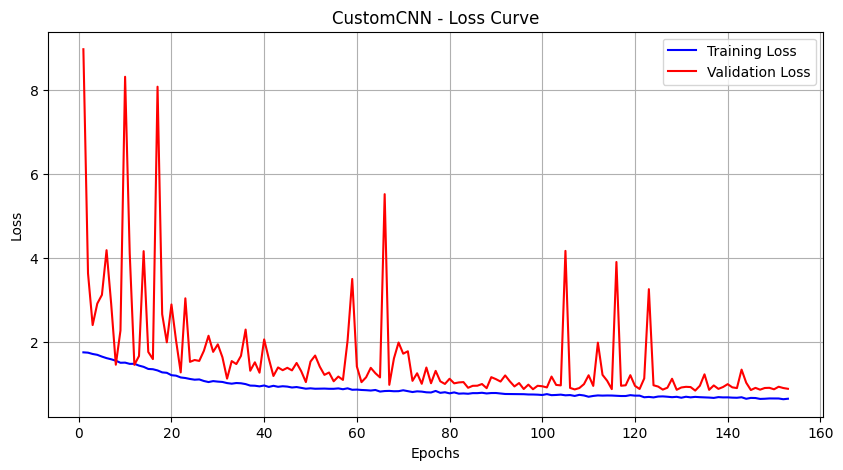

Accuracy plot saved to: ./plots/CustomCNN_accuracy.png


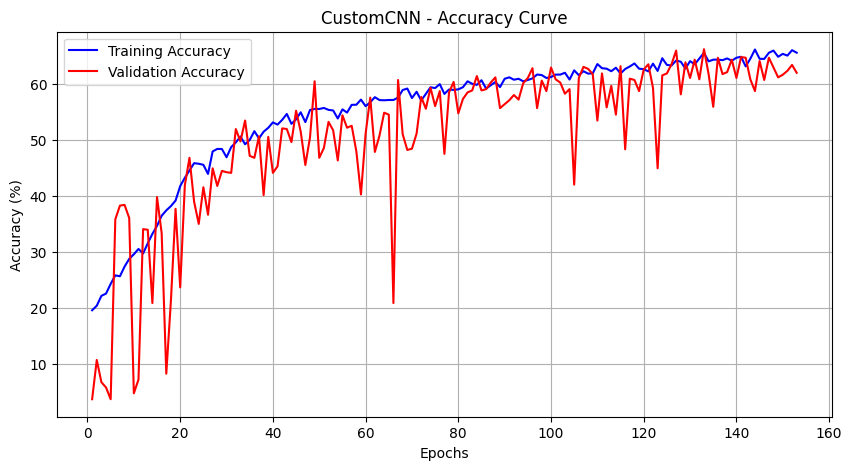

In [15]:
plot_training_history(history_cnn, model_name='CustomCNN')


MODEL 1/3: DENSENET121 (IMAGENET)
Initializing imagenet DenseNet with Fine-Tuning...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 210MB/s]


  -> Frozen layers: Initial Conv, DenseBlock 1-3
  -> Unfrozen layers: DenseBlock 4, Norm5, Classifier
Starting training for 100 epochs. Best model will be saved to 'best_densenet_finetuned.pth'
Epoch [1/100] Train Loss: 1.4367 Acc: 33.95% | Val Loss: 1.3226 Acc: 37.15%
  >>> New Best Model Saved! (Val Loss: 1.3226)
Epoch [2/100] Train Loss: 1.2087 Acc: 45.15% | Val Loss: 1.1448 Acc: 48.01%
  >>> New Best Model Saved! (Val Loss: 1.1448)
Epoch [3/100] Train Loss: 1.1092 Acc: 47.98% | Val Loss: 1.1012 Acc: 50.93%
  >>> New Best Model Saved! (Val Loss: 1.1012)
Epoch [4/100] Train Loss: 1.0530 Acc: 50.58% | Val Loss: 1.0786 Acc: 51.87%
  >>> New Best Model Saved! (Val Loss: 1.0786)
Epoch [5/100] Train Loss: 1.0000 Acc: 51.19% | Val Loss: 1.0821 Acc: 51.75%
Epoch [6/100] Train Loss: 0.9688 Acc: 52.54% | Val Loss: 1.0631 Acc: 51.29%
  >>> New Best Model Saved! (Val Loss: 1.0631)
Epoch [7/100] Train Loss: 0.9578 Acc: 53.30% | Val Loss: 1.0327 Acc: 53.86%
  >>> New Best Model Saved! (Val Loss:

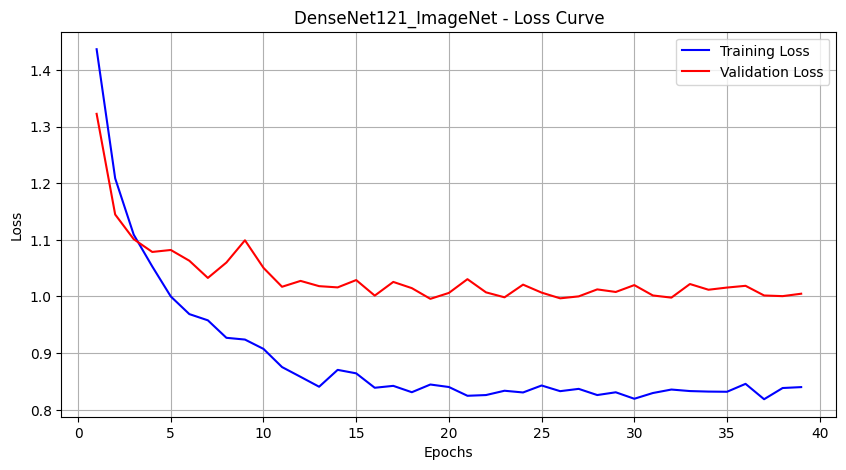

Accuracy plot saved to: ./plots/DenseNet121_ImageNet_accuracy.png


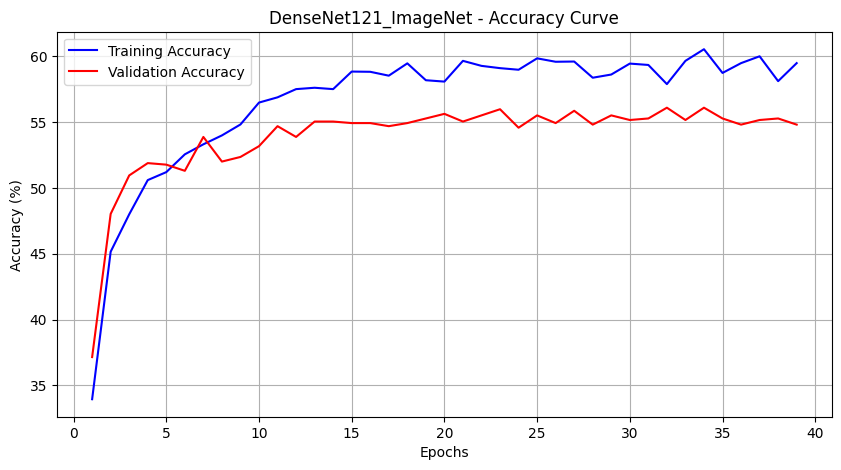


MODEL 2/3: TORCHXRAYVISION (MEDICAL)
Initializing xray DenseNet with Fine-Tuning...
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
  -> Frozen layers: Initial Conv, DenseBlock 1-3
  -> Unfrozen layers: DenseBlock 4, Norm5, Classifier
Starting training for 100 epochs. Best model will be saved to 'best_txv_finetuned.pth'
Epoch [1/100] Train Loss: 1.6087 Acc: 23.93% | Val Loss: 1.5871 Acc: 27.57%
  >>> New Best Model Saved! (Val Loss: 1.5871)
Epoch [2/100] Train Loss: 1.5933 Acc: 31.89% | Val Loss: 1.5575 Acc: 26.99%
  >>> New Best Model Saved! (Val Loss: 1.5575)
Epoch [3/100] Train Loss: 1.5756 Acc: 31.82% | Val Loss: 1.5332 Acc: 27.34%
  >>> New Best Model Sa

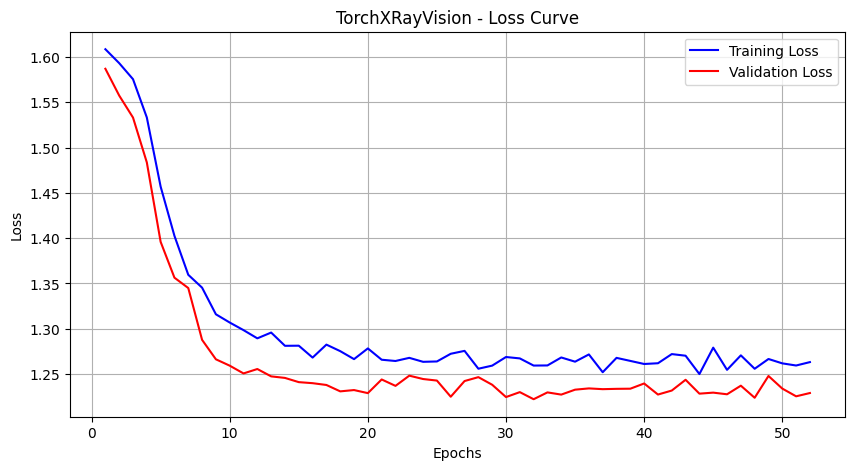

Accuracy plot saved to: ./plots/TorchXRayVision_accuracy.png


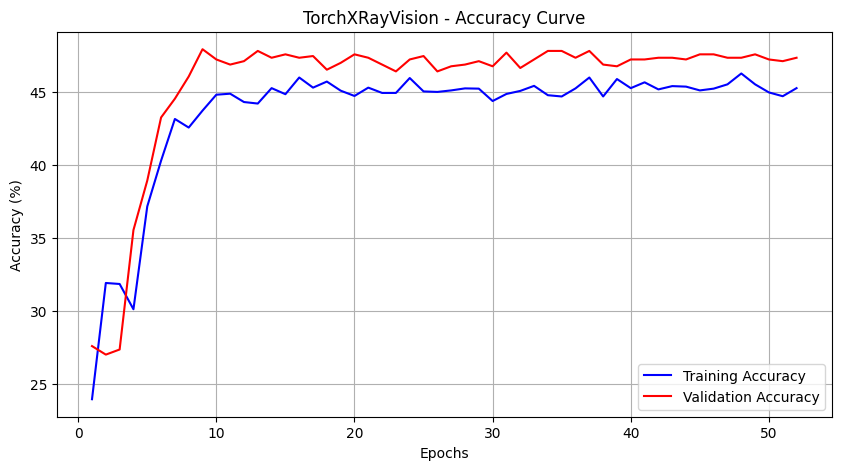


MODEL 3/3: ALEXNET (IMAGENET)
Initializing Fine-Tuned AlexNet...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 218MB/s] 


  -> Frozen layers: Conv 1-4
  -> Unfrozen layers: Conv 5, All Linear Layers
Starting training for 100 epochs. Best model will be saved to 'best_alexnet_finetuned.pth'
Epoch [1/100] Train Loss: 1.4578 Acc: 33.66% | Val Loss: 1.2887 Acc: 35.86%
  >>> New Best Model Saved! (Val Loss: 1.2887)
Epoch [2/100] Train Loss: 1.2745 Acc: 38.55% | Val Loss: 1.2383 Acc: 41.59%
  >>> New Best Model Saved! (Val Loss: 1.2383)
Epoch [3/100] Train Loss: 1.2234 Acc: 42.62% | Val Loss: 1.2014 Acc: 37.85%
  >>> New Best Model Saved! (Val Loss: 1.2014)
Epoch [4/100] Train Loss: 1.1484 Acc: 44.87% | Val Loss: 1.1260 Acc: 47.43%
  >>> New Best Model Saved! (Val Loss: 1.1260)
Epoch [5/100] Train Loss: 1.1412 Acc: 44.44% | Val Loss: 1.1362 Acc: 46.14%
Epoch [6/100] Train Loss: 1.0861 Acc: 47.29% | Val Loss: 1.0961 Acc: 50.93%
  >>> New Best Model Saved! (Val Loss: 1.0961)
Epoch [7/100] Train Loss: 1.0598 Acc: 47.45% | Val Loss: 1.1023 Acc: 49.88%
Epoch [8/100] Train Loss: 1.0542 Acc: 48.11% | Val Loss: 1.1321 A

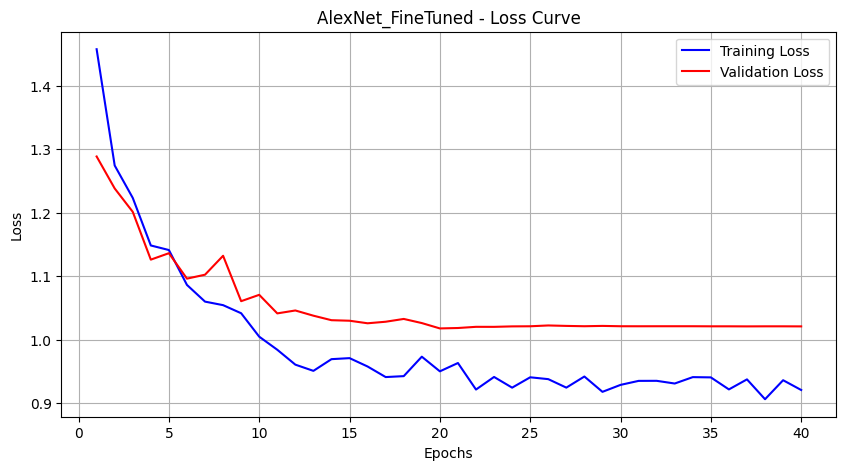

Accuracy plot saved to: ./plots/AlexNet_FineTuned_accuracy.png


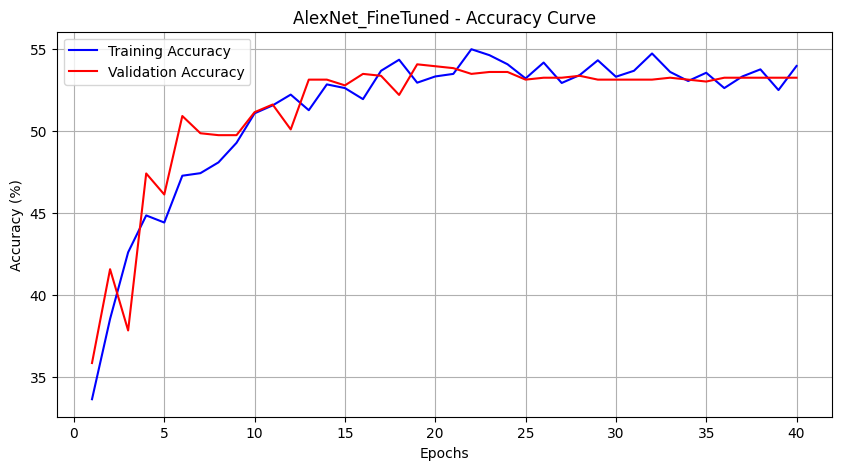

In [16]:
# --- GLOBAL SETTINGS ---
BATCH_SIZE = 32
LR_FINETUNE = 1e-4  # Smaller Learning Rate for Fine-Tuning is safer
NUM_EPOCHS = 100

# Define Scheduler Factory (To create a fresh scheduler for each model)
def get_scheduler(optimizer):
    return lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# ==========================================
# 1. TRAIN DENSENET121 (IMAGENET)
# ==========================================
print("\n" + "="*40)
print("MODEL 1/3: DENSENET121 (IMAGENET)")
print("="*40)

# Initialize with Fine-Tuning (Last Block Unfrozen)
model_dense = get_finetuned_densenet("imagenet", num_classes=5).to(device)

# Optimizer (Only updates unfrozen params)
optimizer_dense = optim.Adam(
    filter(lambda p: p.requires_grad, model_dense.parameters()), 
    lr=LR_FINETUNE
)

# Train (IMPORTANT: Use RGB Loaders)
model_dense, history_dense = train_model(
    model=model_dense,
    train_loader=train_loader_rgb,  # <--- RGB
    val_loader=val_loader_rgb,      # <--- RGB
    criterion=criterion,
    optimizer=optimizer_dense,
    device=device,
    scheduler=get_scheduler(optimizer_dense),
    num_epochs=NUM_EPOCHS,
    save_path='best_densenet_finetuned.pth'
)

# Plot & Save Results
plot_training_history(history_dense, model_name='DenseNet121_ImageNet')


# ==========================================
# 2. TRAIN TORCHXRAYVISION (MEDICAL)
# ==========================================
print("\n" + "="*40)
print("MODEL 2/3: TORCHXRAYVISION (MEDICAL)")
print("="*40)

# Initialize with Fine-Tuning
model_txv = get_finetuned_densenet("xray", num_classes=5).to(device)

# Optimizer
optimizer_txv = optim.Adam(
    filter(lambda p: p.requires_grad, model_txv.parameters()), 
    lr=LR_FINETUNE
)

# Train (IMPORTANT: Use Grayscale Loaders)
model_txv, history_txv = train_model(
    model=model_txv,
    train_loader=train_loader,      # <--- Grayscale (1 Channel)
    val_loader=val_loader,          # <--- Grayscale
    criterion=criterion,
    optimizer=optimizer_txv,
    device=device,
    scheduler=get_scheduler(optimizer_txv),
    num_epochs=NUM_EPOCHS,
    save_path='best_txv_finetuned.pth'
)

# Plot & Save Results
plot_training_history(history_txv, model_name='TorchXRayVision')


# ==========================================
# 3. TRAIN ALEXNET (IMAGENET)
# ==========================================
print("\n" + "="*40)
print("MODEL 3/3: ALEXNET (IMAGENET)")
print("="*40)

# Initialize with Fine-Tuning (Last Conv Unfrozen)
model_alex = get_finetuned_alexnet(num_classes=5).to(device)

# Optimizer
optimizer_alex = optim.Adam(
    filter(lambda p: p.requires_grad, model_alex.parameters()), 
    lr=LR_FINETUNE
)

# Train (IMPORTANT: Use RGB Loaders)
model_alex, history_alex = train_model(
    model=model_alex,
    train_loader=train_loader_rgb,  # <--- RGB
    val_loader=val_loader_rgb,      # <--- RGB
    criterion=criterion,
    optimizer=optimizer_alex,
    device=device,
    scheduler=get_scheduler(optimizer_alex),
    num_epochs=NUM_EPOCHS,
    save_path='best_alexnet_finetuned.pth'
)

# Plot & Save Results
plot_training_history(history_alex, model_name='AlexNet_FineTuned')